In [3]:
import torch
import numpy as np
import yaml
from utils import *

from tqdm import tqdm
from pesq import pesq
from pystoi import stoi
import random
from torch.utils.data import Subset
import soundfile as sf
from datetime import datetime

from IPython.display import Audio, display
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from dataset import CustomDataset

from models.SEANet_TFiLM import SEANet_TFiLM
from models.SEANet_TFiLM_nok import SEANet_TFiLM as SEANet_TFiLM_nok
from models.SEANet import SEANet

DEVICE = 'cuda'
def load_model(model, checkpoint_path):
    model = model.to(DEVICE)
    ckpt = torch.load(checkpoint_path)
    model.load_state_dict(ckpt['generator_state_dict'])
    print(f"Model loaded from {checkpoint_path}")
    return model

In [4]:
## Load Dataset
config_path = "configs/K64_main.yaml"
config = yaml.load(open(config_path, "r"), Loader=yaml.FullLoader)
test_dataset = CustomDataset(path_dir_nb=config['dataset']['nb_test'], 
                                 path_dir_wb=config['dataset']['wb_test'], seg_len=config['dataset']['seg_len'], mode="train")

# ## For USAC44 Dataset
# path_wb = ["/home/woongjib/Projects/USAC44_mono_48k"]
# path_nb = ["/home/woongjib/Projects/USAC44_mono_48k_HEAAC16_LPF_Crop"]
# test_dataset = CustomDataset(path_dir_nb=path_nb, 
#                                  path_dir_wb=path_wb, seg_len=3, mode="val")

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

idx=13
hr, lr, cond, name, _ = test_dataset[idx]

for hr, lr, cond, name, _ in test_dataloader:
    break

print(hr.shape)
print(lr.shape)
print(name)
print(cond.shape)

# sf.write("HR.wav", hr.squeeze().cpu().numpy(), samplerate=48000)
# sf.write("LR.wav", lr.squeeze().cpu().numpy(), samplerate=48000)

# t1 = draw_spec(hr.squeeze().numpy(), figsize=(15,4), sr=48000, win_len=2048, hop_len=2048, use_colorbar=True, 
#               save_fig=True, save_path="hr.png")
# t2 = draw_spec(lr.squeeze().numpy(), figsize=(15,4), sr=48000, win_len=2048, hop_len=2048, use_colorbar=True,
#               save_fig=True, save_path="lr.png")


Index:0 with 105051 samples
Index:1 with 62475 samples
LR 167526 and HR 167526 file numbers loaded!
train: 167526 files loaded
torch.Size([1, 1, 43200])
torch.Size([1, 1, 43200])
('100030_mono_segment_0',)
torch.Size([1, 1, 320, 21])


/home/woongjib/anaconda3/envs/env2/lib/python3.12/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.4.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/woongjib/anaconda3/envs/env2/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


**** CHECKPOINT LOADED! **** 
Model loaded from /home/woongjib/Projects/BESSL__/ckpt_BESSL_AAC13.5/ckpt_K64/epoch_41_lsdH_0.441.pth
Model loaded from /home/woongjib/Projects/BESSL__/ckpt_BESSL_AAC13.5/ckpt_baseline/epoch_41_lsdH_0.546.pth
62459_mono_segment_7


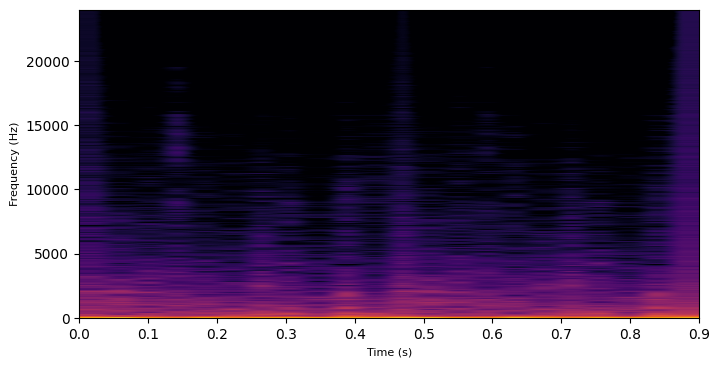

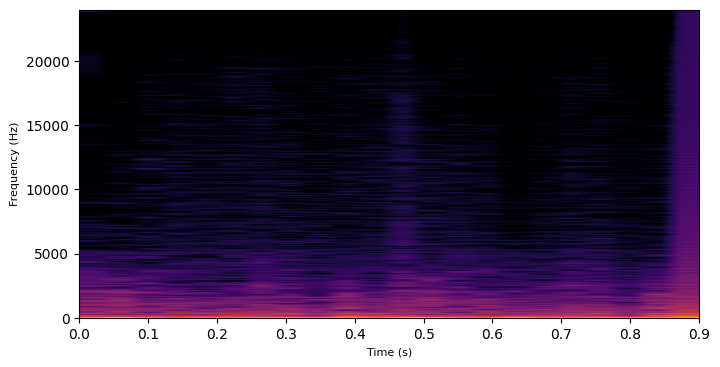

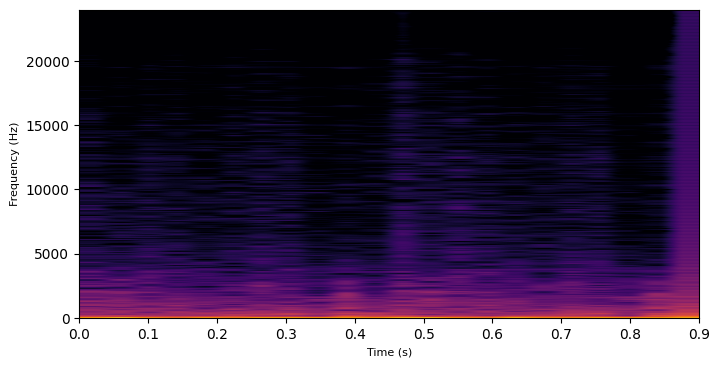

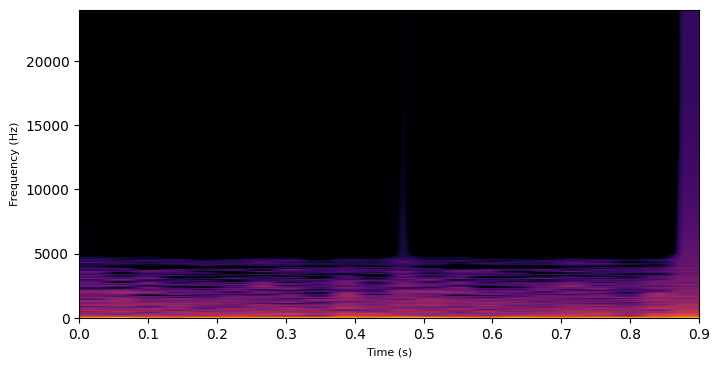

432211_mono_segment_13


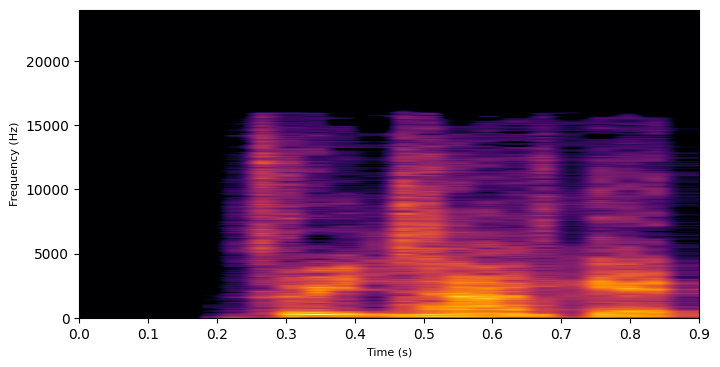

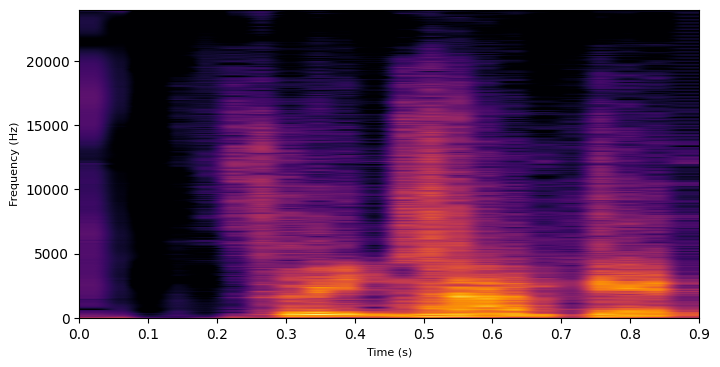

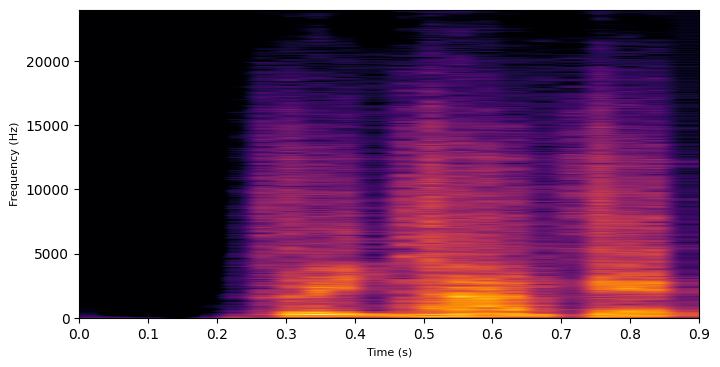

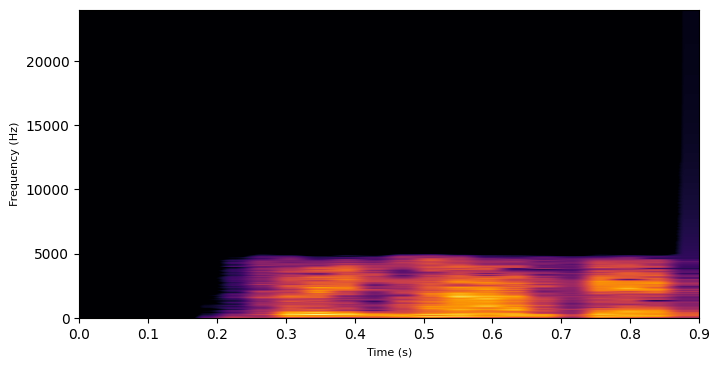

328146_mono_segment_9


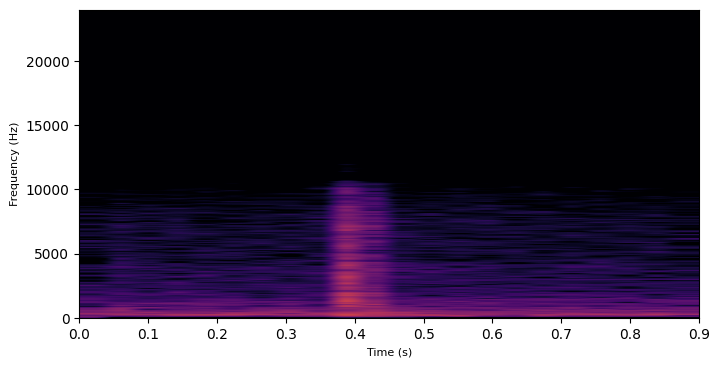

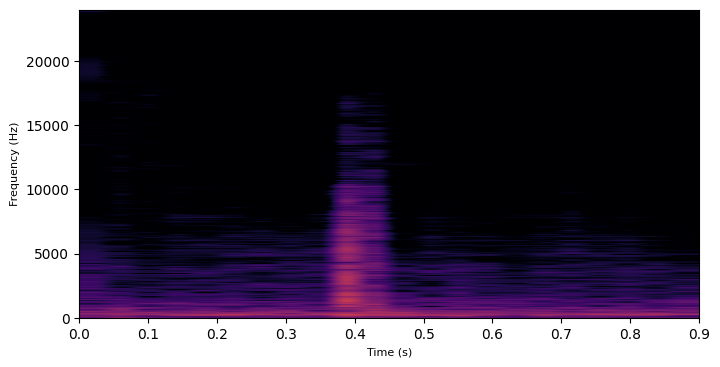

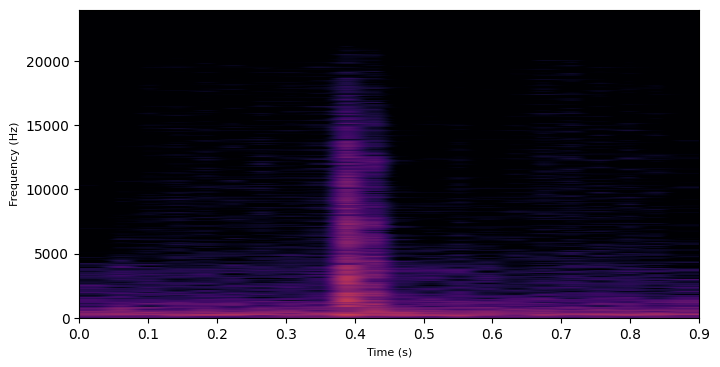

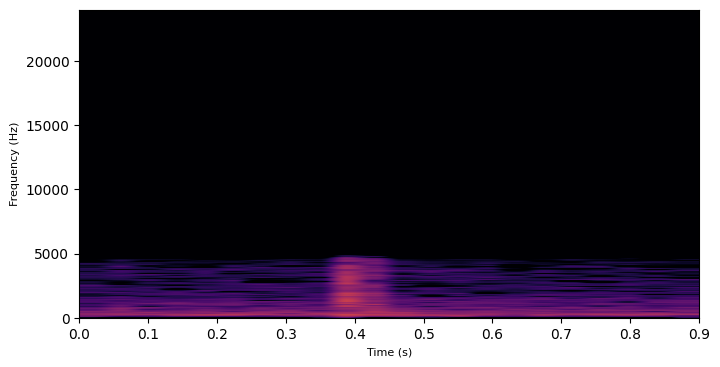

In [47]:
## Load Model
config_path = "configs/K64_main.yaml"
model = SEANet_TFiLM(kmeans_model_path=config['model']['kmeans_path'])
model = load_model(model, "/home/woongjib/Projects/BESSL__/ckpt_BESSL_AAC13.5/ckpt_K64/epoch_41_lsdH_0.441.pth")

# config_path = "configs/K256.yaml"
# config = yaml.load(open(config_path, "r"), Loader=yaml.FullLoader)
# model = SEANet_TFiLM(kmeans_model_path=config['model']['kmeans_path'])
# model = load_model(model, "/home/woongjib/Projects/BESSL__/ckpt_BESSL_AAC13.5/ckpt_K256/epoch_94_lsdH_0.459.pth")

# model = SEANet_TFiLM_nok(kmeans_model_path=config['model']['kmeans_path'])
# model = load_model(model, "/home/woongjib/Projects/BESSL__/ckpt_BESSL_AAC13.5/ckpt_nok/epoch_13_lsdH_0.430.pth")

model_base = SEANet()
model_base = load_model(model_base, "/home/woongjib/Projects/BESSL__/ckpt_BESSL_AAC13.5/ckpt_baseline/epoch_41_lsdH_0.546.pth")

## Loop
lsd_list = []
lsd_list_b = []
lsd_list_nb = []

seed_value = 57
# 43 53 55
rng = np.random.RandomState(seed_value)
random_numbers = rng.choice(np.arange(len(test_dataset)), size=3, replace=False)

for idx in random_numbers:
    wb, nb, cond, name, _ = test_dataset[idx]
    print(name)
    with torch.no_grad():
        recon = model(nb.to(DEVICE), cond.to(DEVICE))
        recon_b = model_base(nb.to(DEVICE), cond.to(DEVICE))
        
        a = lsd_batch(wb.cpu(), recon.cpu(), fs=48000)
        b = lsd_batch(wb.cpu(), recon_b.cpu(), fs=48000)
        c = lsd_batch(wb.cpu(), nb.cpu(), fs=48000)
        
        lsd_list.append(a)
        lsd_list_b.append(b)
        lsd_list_nb.append(c)

        figsize=(8,4)
        t1 = draw_spec(wb.squeeze().numpy(), figsize=figsize, sr=48000, win_len=2048, hop_len=2048, use_colorbar=False, 
              save_fig=True, save_path="hr")
        t2 = draw_spec(recon.squeeze().cpu().numpy(), figsize=figsize, sr=48000, win_len=2048, hop_len=2048, use_colorbar=False,
                    save_fig=True, save_path="bwe")
        t2 = draw_spec(recon_b.squeeze().cpu().numpy(), figsize=figsize, sr=48000, win_len=2048, hop_len=2048, use_colorbar=False,
                    save_fig=True, save_path="bwe_b")
        t3 = draw_spec(nb.squeeze().cpu().numpy(), figsize=figsize, sr=48000, win_len=2048, hop_len=2048, use_colorbar=False,
                    save_fig=True, save_path="lr")    
        
        sf.write(f"outputs/{name}_bwe.wav", recon.squeeze().cpu().numpy(), samplerate=48000)
        sf.write(f"outputs/{name}_bwe_base.wav", recon_b.squeeze().cpu().numpy(), samplerate=48000)
        sf.write(f"outputs/{name}_gt.wav", wb.squeeze().cpu().numpy(), samplerate=48000)

        display(Audio(wb.cpu().numpy(), rate=48000))
        display(Audio(recon.squeeze().cpu().numpy(), rate=48000))
        display(Audio(recon_b.squeeze().cpu().numpy(), rate=48000))
        display(Audio(nb.cpu().numpy(), rate=48000))
        
# average_lsd = sum(lsd_list) / len(lsd_list)
# average_lsd_b = sum(lsd_list_b) / len(lsd_list)
# average_lsd_nb = sum(lsd_list_nb) / len(lsd_list)

# print(f"\nAverage LSD for the 20 samples: {average_lsd:.3f}")
# print(f"Average LSD base for the 20 samples: {average_lsd_b:.3f}")
# print(f"Average LSD nb for the 20 samples: {average_lsd_nb:.3f}")

# t1 = draw_spec(wb.squeeze().numpy(), figsize=(15,4), sr=48000, win_len=2048, hop_len=2048, use_colorbar=True, 
#               save_fig=True, save_path="hr")
# t2 = draw_spec(recon.squeeze().cpu().numpy(), figsize=(15,4), sr=48000, win_len=2048, hop_len=2048, use_colorbar=True,
#               save_fig=True, save_path="bwe")
# t2 = draw_spec(recon_b.squeeze().cpu().numpy(), figsize=(15,4), sr=48000, win_len=2048, hop_len=2048, use_colorbar=True,
#               save_fig=True, save_path="bwe_b")
# t3 = draw_spec(nb.squeeze().cpu().numpy(), figsize=(15,4), sr=48000, win_len=2048, hop_len=2048, use_colorbar=True,
#               save_fig=True, save_path="lr")    

# sf.write("bwe.wav", recon.squeeze().cpu().numpy(), samplerate=48000)
# sf.write("bwe_b.wav", recon_b.squeeze().cpu().numpy(), samplerate=48000)

# 15425536831381643598
## 8495

In [49]:
## Load Model
model_64 = SEANet_TFiLM(kmeans_model_path=config['model']['kmeans_path'])
model_64 = load_model(model_64, "/home/woongjib/Projects/BESSL__/ckpt_BESSL_AAC13.5/ckpt_K64/epoch_41_lsdH_0.441.pth")

model_256 = SEANet_TFiLM(kmeans_model_path=config['model']['kmeans_path'])
model_256 = load_model(model_256, "/home/woongjib/Projects/BESSL__/ckpt_BESSL_AAC13.5/ckpt_K256/epoch_94_lsdH_0.459.pth")

model_nok = SEANet_TFiLM_nok(kmeans_model_path=config['model']['kmeans_path'])
model_nok = load_model(model_nok, "/home/woongjib/Projects/BESSL__/ckpt_BESSL_AAC13.5/ckpt_nok/epoch_13_lsdH_0.430.pth")

model_base = SEANet()
model_base = load_model(model_base, "/home/woongjib/Projects/BESSL__/ckpt_BESSL_AAC13.5/ckpt_baseline/epoch_41_lsdH_0.546.pth")

## Loop
lsd_list = []
lsd_list_b = []
lsd_list_nb = []

seed_value = 57
rng = np.random.RandomState(seed_value)
random_numbers = rng.choice(np.arange(len(test_dataset)), size=3, replace=False)

for idx in random_numbers:
    wb, nb, cond, name, _ = test_dataset[idx]
    print(name)
    with torch.no_grad():
        recon_64 = model_64(nb.to(DEVICE), cond.to(DEVICE))
        recon_256 = model_256(nb.to(DEVICE), cond.to(DEVICE))
        recon_nok = model_nok(nb.to(DEVICE), cond.to(DEVICE))
        recon_b = model_base(nb.to(DEVICE), cond.to(DEVICE))
        
        # LSD 계산
        a = lsd_batch(wb.cpu(), recon_64.cpu(), fs=48000)
        b = lsd_batch(wb.cpu(), recon_b.cpu(), fs=48000)
        c = lsd_batch(wb.cpu(), nb.cpu(), fs=48000)
        d = lsd_batch(wb.cpu(), recon_256.cpu(), fs=48000)
        e = lsd_batch(wb.cpu(), recon_nok.cpu(), fs=48000)
        
        lsd_list.append(a)
        lsd_list_b.append(b)
        lsd_list_nb.append(c)

        figsize=(8,4)
        # Ground Truth (wb)와 각 모델의 recon, nb
        t1 = draw_spec(wb.squeeze().numpy(), figsize=figsize, sr=48000, win_len=2048, hop_len=2048, use_colorbar=False, save_fig=True, save_path="hr")
        t2 = draw_spec(recon_64.squeeze().cpu().numpy(), figsize=figsize, sr=48000, win_len=2048, hop_len=2048, use_colorbar=False, save_fig=True, save_path="bwe_64")
        t3 = draw_spec(recon_256.squeeze().cpu().numpy(), figsize=figsize, sr=48000, win_len=2048, hop_len=2048, use_colorbar=False, save_fig=True, save_path="bwe_256")
        t4 = draw_spec(recon_b.squeeze().cpu().numpy(), figsize=figsize, sr=48000, win_len=2048, hop_len=2048, use_colorbar=False, save_fig=True, save_path="bwe_b")
        t5 = draw_spec(recon_nok.squeeze().cpu().numpy(), figsize=figsize, sr=48000, win_len=2048, hop_len=2048, use_colorbar=False, save_fig=True, save_path="bwe_nok")
        t6 = draw_spec(nb.squeeze().cpu().numpy(), figsize=figsize, sr=48000, win_len=2048, hop_len=2048, use_colorbar=False, save_fig=True, save_path="lr")
        
        # 오디오 파일 저장
        sf.write(f"outputs/{name}_bwe_64.wav", recon_64.squeeze().cpu().numpy(), samplerate=48000)
        sf.write(f"outputs/{name}_bwe_256.wav", recon_256.squeeze().cpu().numpy(), samplerate=48000)
        sf.write(f"outputs/{name}_bwe_base.wav", recon_b.squeeze().cpu().numpy(), samplerate=48000)
        sf.write(f"outputs/{name}_bwe_nok.wav", recon_nok.squeeze().cpu().numpy(), samplerate=48000)
        sf.write(f"outputs/{name}_gt.wav", wb.squeeze().cpu().numpy(), samplerate=48000)

        # 오디오 재생
        display(Audio(wb.cpu().numpy(), rate=48000))
        display(Audio(recon_64.squeeze().cpu().numpy(), rate=48000))
        display(Audio(recon_256.squeeze().cpu().numpy(), rate=48000))
        display(Audio(recon_b.squeeze().cpu().numpy(), rate=48000))
        display(Audio(recon_nok.squeeze().cpu().numpy(), rate=48000))
        display(Audio(nb.cpu().numpy(), rate=48000))


**** CHECKPOINT LOADED! **** 
Model loaded from /home/woongjib/Projects/BESSL__/ckpt_BESSL_AAC13.5/ckpt_K64/epoch_41_lsdH_0.441.pth
**** CHECKPOINT LOADED! **** 


FileNotFoundError: [Errno 2] No such file or directory: '/home/woongjib/Projects/BESSL__/ckpt_BESSL__/ckpt_K256/epoch_94_lsdH_0.459.pth'